In [37]:
print('Kernel Initialized')

Kernel Initialized


In [1]:
# Imports
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from utils import Utils
#import plot_utils as plotting
import toml
from sklearn import preprocessing, model_selection, metrics
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use("seaborn-v0_8-whitegrid")
import mplhep as hep
hep.style.use(hep.style.ATLAS)
from scipy.special import logit, expit
import os

mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'stixgeneral',
    'mathtext.fontset': 'stix',
    })

#import verstack

random.seed(42)


In [2]:
def load_multiple_feather_files(file_list:list, selection:str, N_events:int, columns_to_read:list):
    print('Starts loading files..')
    files = []
    List_uniques_list = []
    for file_path in file_list:
        files.append(pd.read_feather(path=file_path, columns=columns_to_read, use_threads=True, storage_options=None))
    print('Done loading..')

    for i in range(len(files)):
        files[i] = files[i].query(selection)
        List_uniques = list(files[i]['info_event_number'].unique()[:N_events])
        List_uniques_list.append(List_uniques)
        files[i] = files[i][(files[i]['info_event_number'].isin(List_uniques))]

    print(f"Number of uniques: {[len(i) for i in List_uniques_list]}, total = {sum([len(i) for i in List_uniques_list])}")
    print(f"Length of files: {[len(i) for i in files]}, total = {sum([len(i) for i in files])}")

    df_files = pd.concat(files)
    print('Done..')
    print()

    return df_files

config = toml.load('config.toml')

Features_to_be_read = []
for k, v in config['features'].items():
    Features_to_be_read.extend(v)
#Features_to_be_read = ['BeeKst_diElectron_mass','B_mass_Kstar_mass_closer','BeeKst_B_mass','BeeKst_diElectron_gsf_id_isOK','info_event_number']

files_dictionary = {
    'MC_signal': sorted([config['PATHS']['feather'] + x for x in os.listdir(config['PATHS']['feather']) if 'MC_signal_all_ntuple' in x ]),
    'Data': sorted([config['PATHS']['feather'] + x for x in os.listdir(config['PATHS']['feather']) if 'Data_All_K_ntuple-data18_13TeV_periodK_part' in x ])
    }

Data_full = load_multiple_feather_files(
    file_list = files_dictionary['Data'], 
    selection = Utils.selection_cuts()['main'],
    N_events = -1, 
    columns_to_read = Features_to_be_read)

Starts loading files..
Done loading..
Number of uniques: [107128, 100613, 89653, 87702, 81122, 81064, 75831, 57811, 46439, 53949, 67173], total = 848485
Length of files: [2612166, 2434696, 2193172, 2147878, 1964466, 1985248, 1858130, 1463502, 1157470, 1428218, 1751054], total = 20996000
Done..



In [3]:
MC_full = load_multiple_feather_files(
    file_list = files_dictionary['MC_signal'], 
    selection = Utils.selection_cuts()['main'],
    N_events = -1, 
    columns_to_read = Features_to_be_read)

Starts loading files..
Done loading..
Number of uniques: [268858, 264696, 147707, 38633, 267888, 269620, 26337, 64119, 65129], total = 1412987
Length of files: [2378943, 2351229, 1313202, 344270, 2373234, 2390138, 234637, 563263, 577706], total = 12526622
Done..



In [4]:
MC_filter_nonres = (MC_full.info_is_true_nonres_Bd == 1) | (MC_full.info_is_true_nonres_BdBar == 1)
MC_filter_res = (MC_full.info_is_true_res_Bd==1) | (MC_full.info_is_true_res_BdBar==1)
MC_filter = MC_filter_nonres | MC_filter_res



In [40]:
MC_full.B_mass[MC_filter_nonres]

16        5376.057129
19        5274.073730
22        5002.835938
39        5078.310547
48        5232.052734
             ...     
240062    4412.382324
240063    5122.345703
240084    5497.819336
240107    5405.573730
240110    5267.500000
Name: B_mass, Length: 981955, dtype: float32

[(2000.0, 8000.0)]

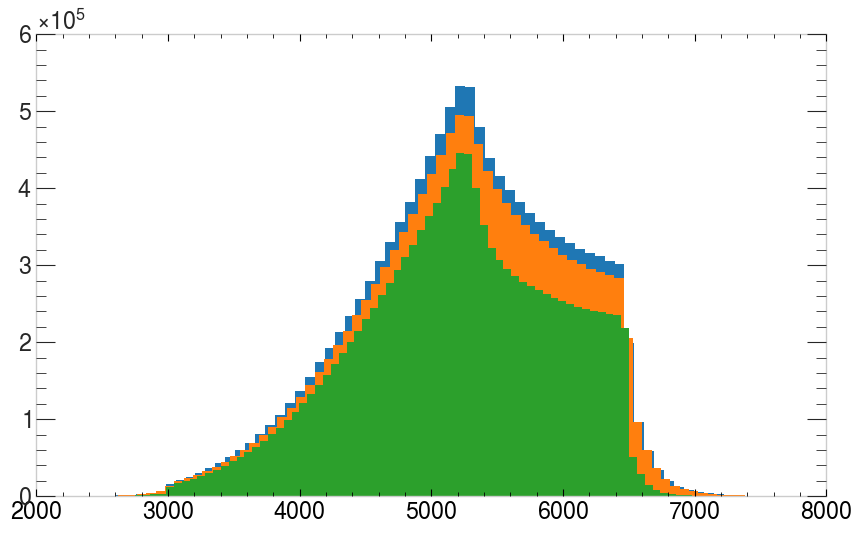

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

#ax.hist(Data_full.B_mass,bins=100)
ax.hist(MC_full.BeeKst_B_mass,bins=100)
ax.hist(MC_full.BeeKst_Bbar_mass,bins=100)
ax.hist(MC_full.B_mass_Kstar_mass_closer,bins=100)
ax.set(xlim=(2000,8000))

In [17]:
(Data_full.info_is_true_nonres_BdBar == 0)

0          True
1          True
2          True
3          True
4          True
           ... 
2039177    True
2039178    True
2039179    True
2039180    True
2039181    True
Name: info_is_true_nonres_BdBar, Length: 20996000, dtype: bool

In [9]:
MC_full_=MC_full[(MC_full.info_is_true_nonres_Bd == 1) + (MC_full.info_is_true_nonres_BdBar == 1) + (MC_full.info_is_true_res_Bd == 1) + (MC_full.info_is_true_res_BdBar == 1)]



In [42]:
q2low = (1.1e6/(1000**2),6e6/(1000**2))
q2high = (6e6/(1000**2),11e6/(1000**2))
q2low_diff = q2low[1]-q2low[0]
q2high_diff = q2high[1]-q2high[0]
xrange = [3000,6500]
yrange=[0,15]
sidebands = (4000,5700)

In [5]:
np.array([6e6/(1000**2),11e6/(1000**2)])

array([ 6., 11.])

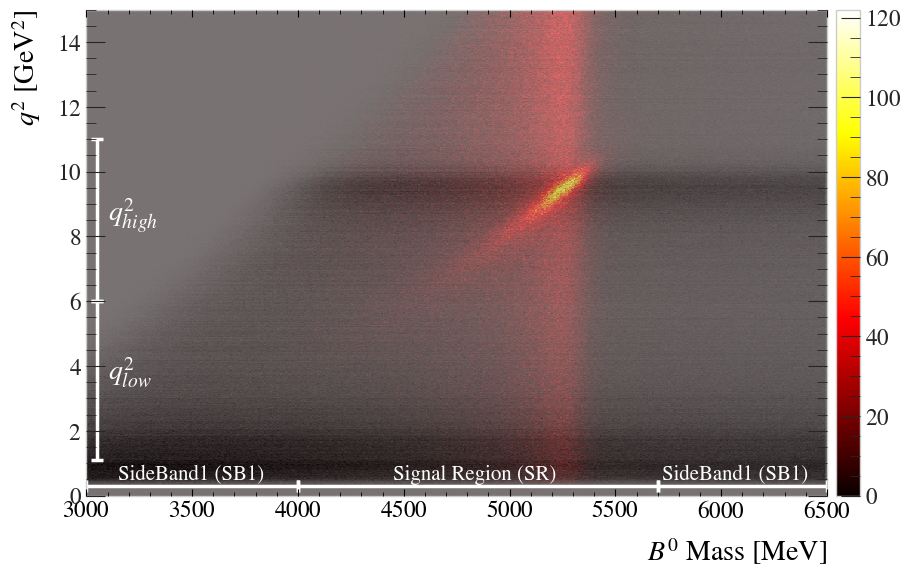

In [23]:
q2 = Data_full.BeeKst_diElectron_mass**2 / (1000**2)
bmass = Data_full.B_mass_Kstar_mass_closer#BeeKst_B_mass
bmass2 = MC_full_.B_mass_Kstar_mass_closer#BeeKst_B_mass
q2_2 = MC_full_.BeeKst_diElectron_mass**2 / (1000**2)

q2low = (1.1e6/(1000**2),6e6/(1000**2))
q2high = (6e6/(1000**2),11e6/(1000**2))
xrange = [3000,6500]
yrange=[0,15]
sidebands = (4000,5700)

fig, ax = plt.subplots(figsize=(10, 6)) 


H = ax.hist2d(bmass2,q2_2, bins=500,cmin=0,cmap='hot',density=False,range=[xrange,yrange],alpha=1)#,norm=mpl.colors.LogNorm())
H2 = ax.hist2d(bmass,q2, bins=500,cmin=0,cmap='binary',density=False,range=[xrange,yrange],alpha=0.45)#,norm=mpl.colors.LogNorm())


fig.colorbar(H[3], ax=ax, pad=0.01)



ax.errorbar(xrange[0]+50,q2low[1]-np.diff(q2low)/2,yerr=np.diff(q2low)/2,capsize=4.5,lw=2.5,capthick=2.5,c='white',ls='--')
ax.text(xrange[0]+50+50, q2low[1]-np.diff(q2low)/2, r'$q_{low}^2$',fontsize=20,c='white')

ax.errorbar(xrange[0]+50,q2high[1]-np.diff(q2high)/2,yerr=np.diff(q2high)/2,capsize=4.5,lw=2.5,capthick=2.5,c='white',ls='--')
ax.text(xrange[0]+50+50, q2high[1]-np.diff(q2high)/2, r'$q_{high}^2$',fontsize=20,c='white')

ax.errorbar(xrange[0]+np.diff((xrange[0],sidebands[0]))/2,yrange[0]+0.3 ,xerr=np.diff((xrange[0],sidebands[0]))/2,capsize=4.5,lw=2.5,capthick=2.5,c='white',ls='--')
ax.text(xrange[0]+np.diff((xrange[0],sidebands[0]))/2-350, yrange[0]+0.3+0.2, r'SideBand1 (SB1)',fontsize=15,c='white')

ax.errorbar(sidebands[1]+np.diff((sidebands[1],xrange[1]))/2,yrange[0]+0.3 ,xerr=np.diff((sidebands[1],xrange[1]))/2,capsize=4.5,lw=2.5,capthick=2.5,c='white',ls='--')
ax.text(xrange[1]-np.diff((sidebands[1],xrange[1]))/2-380, yrange[0]+0.3+0.2, r'SideBand1 (SB1)',fontsize=15,c='white')

ax.errorbar(sidebands[0]+np.diff((sidebands))/2,yrange[0]+0.3 ,xerr=np.diff((sidebands))/2,capsize=4.5,lw=2.5,capthick=2.5,c='white',ls='--')
ax.text(sidebands[0]+np.diff((sidebands))/2-400, yrange[0]+0.3+0.2, r'Signal Region (SR)',fontsize=15,c='white')

ax.set(ylabel=r'$q^2$ [GeV$^2$]', xlabel=r'$B^0$ Mass [MeV]')


plt.tight_layout()

plt.savefig("hist2d.png")
plt.show()